<a href="https://colab.research.google.com/github/ramonlsaraiva/cuda_tests/blob/main/vector_sum_double.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install git+https://github.com/canesche/nvcc4jupyter.git
!git clone https://github.com/canesche/nvcc4jupyter

%load_ext nvcc_plugin
!nvidia-smi

  Cloning https://github.com/canesche/nvcc4jupyter.git to /tmp/pip-req-build-e0cwruc7
  Running command git clone -q https://github.com/canesche/nvcc4jupyter.git /tmp/pip-req-build-e0cwruc7
  Created wheel for ColabPlugin: filename=ColabPlugin-blind-py3-none-any.whl size=12727 sha256=741fcfd9d621187830a854e1114a4da0fb908c2a3b00eb931140dedb008154b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-wm9wczgu/wheels/06/76/5f/88825d3256ab9fe9e4386e23ad33a2c41a2e4dc94f0addff44
Failed to build ColabPlugin
    Running setup.py install for ColabPlugin ... done
  DEPRECATION: ColabPlugin was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
fatal: destination path 'nvcc4jupyter' already exists and is not an empty directory.
Thu Apr  7 03:02:56 2022       
+------------------------------------------

No código abaixo é realizada a soma de vetores de tamanho N=1024*1024, do tipo double. Foram realizados 50 testes para cada número de threads, sendo que os números de threads testados foram: 1, 2, 4, 8, 32, 64, 128, 192, 256, 384, 512, 1024.

In [4]:
%%gpu
 
#include <stdio.h>
#include <stdlib.h>

#include "cuda_runtime.h"
#include "device_launch_parameters.h"


# define N 1024*1024
 

void fill_array(double *data) {
	for(int idx=0;idx<N;idx++)
		data[idx] = idx;
}


int verify_output(double *a, double *b, double *c) {
	int ok = 1;
	
	for (int idx=0;idx<N;idx++)
    	if (a[idx] + b[idx] != c[idx]) ok = 0;

	return ok;
}


__global__ void funcGPU(double *A, double *B, double *C){
	int index = threadIdx.x + blockIdx.x * blockDim.x;
    C[index] = A[index] + B[index];
}


int main(){
    
    unsigned int blk_size[] = {1,2,4,8,32,64,128,192,256,384,512,1024};

	FILE *pFile;
	pFile = fopen("valores.txt", "w"); 

	double *A = (double*) malloc(N*sizeof(double));
	double *B = (double*) malloc(N*sizeof(double));
	double *C = (double*) malloc(N*sizeof(double));

	fill_array(A);
	fill_array(B);

	double *dA, *dB, *dC;

	cudaMalloc(&dA, N*sizeof(double));
	cudaMalloc(&dB, N*sizeof(double));
	cudaMalloc(&dC, N*sizeof(double));

	
	for(int i=0; i<(sizeof blk_size/sizeof (unsigned int)); i++){
		unsigned int nBlocksX = N/blk_size[i];
		printf("Numero de Threads: %i\n", blk_size[i]);
		printf("Numero de Blocos: %i\n", nBlocksX);

		float averageKernel = 0;
		float averageTotal = 0;

		for (int j=1; j<=50; j++){
					
			float timeKernel, timeTotal;
			cudaEvent_t startKernel, endKernel, startTotal, endTotal; 
			cudaEventCreate(&startKernel);
			cudaEventCreate(&endKernel);
			cudaEventCreate(&startTotal);
			cudaEventCreate(&endTotal);

			cudaEventRecord(startTotal);
			cudaMemcpy(dA, A, N*sizeof(double), cudaMemcpyHostToDevice);
			cudaMemcpy(dB, B, N*sizeof(double), cudaMemcpyHostToDevice);
	
			cudaEventRecord(startKernel);
			funcGPU <<< {nBlocksX,1,1}, {blk_size[i],1,1} >>> (dA, dB, dC);
			cudaEventRecord(endKernel);
			cudaEventSynchronize(endKernel);
			cudaEventElapsedTime(&timeKernel, startKernel, endKernel);
			
			cudaMemcpy(C, dC, N*sizeof(double), cudaMemcpyDeviceToHost);
			cudaEventRecord(endTotal);
			cudaEventSynchronize(endTotal);
			cudaEventElapsedTime(&timeTotal, startTotal, endTotal);

			if (verify_output(A,B,C)){
				averageKernel = (averageKernel*(j-1)+timeKernel)/j;
				averageTotal = (averageTotal*(j-1)+timeTotal)/j;
			}
			
			else {
				j=j-1;
				printf("\n*** SOMA ERRADA! ***\n\n");
			}
		}
		
		float gopsTotal = (blk_size[i]*nBlocksX)/(averageTotal*1000000);
		float gopsKernel = (blk_size[i]*nBlocksX)/(averageKernel*1000000);
		
		printf("Tempo Total: %f ms\n", averageTotal);
		printf("Tempo Kernel: %f ms\n\n\n", averageKernel);
		fprintf(pFile, "%i;%f;%f\n", blk_size[i], gopsTotal, gopsKernel);

	}

	fclose(pFile);
	free(A);
	free(B);
	free(C);
	cudaFree(dA);
	cudaFree(dB);
	cudaFree(dC);


	pFile = fopen("modeloGPU.txt", "w"); 
	
	cudaDeviceProp varProp;
	cudaGetDeviceProperties(&varProp,0);
	fprintf(pFile, "%s", varProp.name);
	fclose(pFile);


	return 0;
}

Numero de Threads: 1
Numero de Blocos: 1048576
Tempo Total: 8.282736 ms
Tempo Kernel: 4.877924 ms


Numero de Threads: 2
Numero de Blocos: 524288
Tempo Total: 5.047175 ms
Tempo Kernel: 2.118632 ms


Numero de Threads: 4
Numero de Blocos: 262144
Tempo Total: 4.037344 ms
Tempo Kernel: 1.074052 ms


Numero de Threads: 8
Numero de Blocos: 131072
Tempo Total: 3.541886 ms
Tempo Kernel: 0.563606 ms


Numero de Threads: 32
Numero de Blocos: 32768
Tempo Total: 3.160849 ms
Tempo Kernel: 0.205581 ms


Numero de Threads: 64
Numero de Blocos: 16384
Tempo Total: 3.162593 ms
Tempo Kernel: 0.174406 ms


Numero de Threads: 128
Numero de Blocos: 8192
Tempo Total: 3.112486 ms
Tempo Kernel: 0.170786 ms


Numero de Threads: 192
Numero de Blocos: 5461
Tempo Total: 3.086461 ms
Tempo Kernel: 0.170729 ms


Numero de Threads: 256
Numero de Blocos: 4096
Tempo Total: 3.293385 ms
Tempo Kernel: 0.169979 ms


Numero de Threads: 384
Numero de Blocos: 2730
Tempo Total: 3.306940 ms
Tempo Kernel: 0.171459 ms


Numero de

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


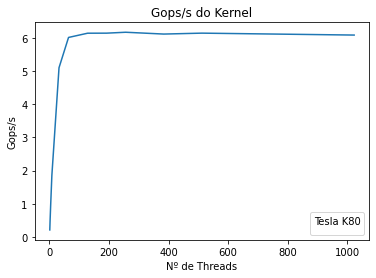

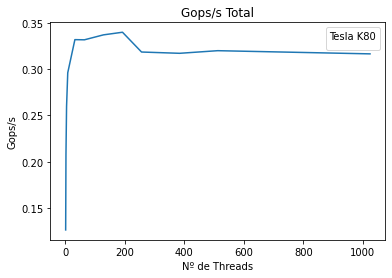

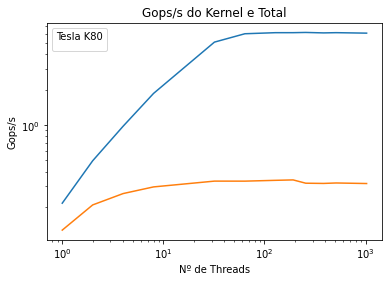

In [5]:
from matplotlib import pyplot

objOpen = open("modeloGPU.txt","r")
modelo = objOpen.read()
objOpen.close()

objOpen = open("valores.txt","r")
valores = objOpen.read()
objOpen.close()
valores = valores.split("\n")
valores = [varFor.split(";") for varFor in valores if varFor!='']

nThreads = [float(varFor[0]) for varFor in valores]
gopsTotal = [float(varFor[1]) for varFor in valores]
gopsKernel = [float(varFor[2]) for varFor in valores]


pyplot.figure()
pyplot.title("Gops/s do Kernel")
pyplot.xlabel("Nº de Threads")
pyplot.ylabel("Gops/s")
pyplot.legend(title=modelo)
pyplot.plot(nThreads, gopsKernel)

pyplot.figure()
pyplot.title("Gops/s Total")
pyplot.xlabel("Nº de Threads")
pyplot.ylabel("Gops/s")
pyplot.legend(title=modelo)
pyplot.plot(nThreads, gopsTotal)

pyplot.figure()
pyplot.title("Gops/s do Kernel e Total")
pyplot.xlabel("Nº de Threads")
pyplot.ylabel("Gops/s")
pyplot.yscale("log")
pyplot.xscale("log")
pyplot.legend(title=modelo)
pyplot.plot(nThreads, gopsKernel)
pyplot.plot(nThreads, gopsTotal)
pyplot.show()